In [ ]:
import pandas as pd
import statsmodels.api as sm
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data/merge_ready

/content/drive/Shareddrives/Data606_Energy/data/merge_ready


In [223]:
data = pd.read_csv('merged_data_2001-2020.csv')

In [224]:
data.shape

(1000, 122)

In [225]:
data.head()

,Year,State,Months Above Average Price Movement BZ=F,Months Above Average Price Volume BZ=F,Months Above Average Price Movement NG=F,Months Above Average Price Volume NG=F,Months Above Average Price Movement CL=F,Months Above Average Price Volume CL=F,Months Above Average Price Movement HO=F,Months Above Average Price Volume HO=F,Hot Summer Months,Cold Winter Months,Dry Summer Months,COV,target_COV,COM_percapita_mean_kWh_electricacc,RES_percapita_mean_kWh_electricacc,COM_percapita_mean_kWh_statepop,RES_percapita_mean_kWh_statepop,Agg_total_plant_MWh_x,Agg_total_plant_count_x,R_AB_MWh,R_AB_count,R_BFG_MWh,R_BFG_count,R_BIT_MWh,R_BIT_count,R_BLQ_MWh,R_BLQ_count,R_DFO_MWh,R_DFO_count,R_GEO_MWh,R_GEO_count,R_JF_MWh,R_JF_count,R_KER_MWh,R_KER_count,R_LFG_MWh,R_LFG_count,R_LIG_MWh,...,R_TDF_count,R_WAT_MWh,R_WAT_count,R_WC_MWh,R_WC_count,R_WDS_MWh,R_WDS_count,R_WH_MWh,R_WH_count,R_WND_MWh,R_WND_count,R_WO_MWh,R_WO_count,Agg_total_plant_MWh_y,Agg_total_plant_count_y,R_Biomass_MWh,R_Biomass_count,R_Coal_MWh,R_Coal_count,R_Geothermal_MWh,R_Geothermal_count,R_Hydroelectric_MWh,R_Hydroelectric_count,R_Municipal_Waste_MWh,R_Municipal_Waste_count,R_Natural_Gas_MWh,R_Natural_Gas_count,R_Nuclear_MWh,R_Nuclear_count,R_Oil_Gas_MWh,R_Oil_Gas_count,R_Other_MWh,R_Other_count,R_Solar_MWh,R_Solar_count,R_Wind_MWh,R_Wind_count,R_batteries_or_other_use_of_electricity_as_an_energy_source_MWh,R_batteries_or_other_use_of_electricity_as_an_energy_source_count,year.1
0,2001.0,AK,0,0,7,7,7,7,4,4,0,2,4,0.035090,0.023952,0.075,0.010,0.435,0.360,5.517773e+06,1032,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,0.051,0.581,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,...,0.000,0.243,0.256,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.012,0.000,0.000,5.517773e+06,1032,0.000,0.000,0.058,0.035,0.000,0.000,0.243,0.256,0.000,0.000,0.543,0.093,0.000,0.000,0.157,0.605,0.0,0.000,0.000,0.000,0.000,0.012,0.0,0.0,NaN
1,2001.0,AL,0,0,7,7,7,7,4,4,0,3,4,0.030268,0.041504,0.017,0.005,0.240,0.354,1.074304e+08,1089,0.000,0.000,0.0,0.0,0.351,0.110,0.017,0.087,0.003,0.159,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.011,0.0,...,0.000,0.082,0.253,0.0,0.0,0.011,0.077,0.0,0.0,0.000,0.000,0.000,0.000,1.074304e+08,1089,0.028,0.175,0.523,0.121,0.000,0.000,0.082,0.253,0.000,0.000,0.082,0.236,0.283,0.022,0.003,0.192,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,NaN
2,2001.0,AR,0,0,7,7,7,7,4,4,0,4,4,0.067610,0.065392,0.082,0.018,0.223,0.368,4.683797e+07,615,0.000,0.000,0.0,0.0,0.002,0.015,0.023,0.073,0.001,0.098,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.0,...,0.007,0.054,0.312,0.0,0.0,0.007,0.055,0.0,0.0,0.000,0.000,0.000,0.018,4.683797e+07,615,0.031,0.148,0.529,0.073,0.000,0.000,0.054,0.312,0.000,0.000,0.052,0.195,0.316,0.020,0.019,0.234,0.0,0.018,0.000,0.000,0.000,0.000,0.0,0.0,NaN
3,2001.0,AZ,0,0,7,7,7,7,4,4,1,4,4,0.097578,0.091424,0.048,0.007,0.370,0.439,7.170267e+07,575,0.000,0.000,0.0,0.0,0.010,0.021,0.000,0.000,0.002,0.292,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.021,0.0,...,0.000,0.110,0.188,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.000,7.170267e+07,575,0.000,0.021,0.312,0.104,0.000,0.000,0.110,0.188,0.000,0.000,0.173,0.290,0.401,0.021,0.004,0.355,0.0,0.000,0.000,0.021,0.000,0.000,0.0,0.0,NaN
4,2001.0,CA,0,0,7,7,7,7,4,4,0,4,4,0.145412,0.071167,0.065,0.008,0.408,0.325,1.343136e+08,6470,0.001,0.002,0.0,0.0,0.007,0.006,0.000,0.000,0.001,0.035,0.087,0.048,0.0,0.0,0.0,0.0,0.006,0.028,0.0,...,0.002,0.187,0.440,0.0,0.0,0.018,0.031,0.0,0.0,0.015,0.064,0.001,0.002,1.343136e+08,6470,0.027,0.075,0.007,0.006,0.087,0.048,0.187,0.440,0.003,0.004,0.521,0.286,0.135,0.002,0.014,0.057,0.0,0.002,0.004,0.017,0.015,0.064,0.0,0.0,NaN


In [226]:
data['target_COV'] = data['target_COV']*1

In [227]:
# break the data up into a train and test split - we have 20 years so I will keep 20% for validation (last 4 years)
test_data = data.copy()[data['Year']>=2017]
train_data = data.copy()[data['Year']<2017]

In [228]:
train_data_year_state = train_data[['Year','State']].copy()

In [229]:
print(test_data.shape)
print(train_data.shape)

(200, 122)
(800, 122)


# Quickly Look at the Target Variable

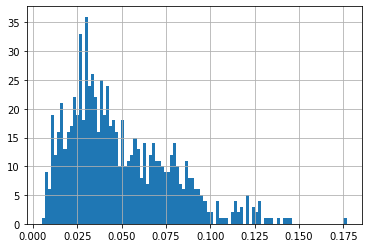

In [230]:
train_data['target_COV'].hist(bins=100)

This is heavily skewed to the right. I wonder if taking the square root would make it look roughly more normal. Also, it looks like there are some outliers which may cause problems in the model so I will take those out.

In [231]:
outlier_thresh = train_data['target_COV'].mean()+3*train_data['target_COV'].std()
print(outlier_thresh)

0.13449065436745125


In [232]:
train_data = train_data.query('target_COV < '+str(outlier_thresh))

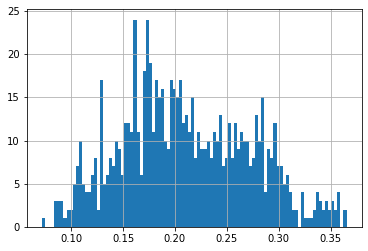

In [233]:
train_data['target_COV'].pow(0.5).hist(bins=100)

This looks better. I will initially use the target COV as is, but may consider trying out the square root in my next steps.

### Create some variables for region based analysis

In [234]:
# variable to track whether states are part of a carbon pricing program - https://www.c2es.org/document/us-state-carbon-pricing-policies/
carbon_policy = ['WA','CA','ME','NH','VT','NY','MA','CT','RI','NJ','MD','DE','VA']
train_data['Carbon Policy'] = train_data['State'].isin(carbon_policy).astype(int)

In [235]:
# variable to show which region a state belongs to
# https://www.nerc.com/AboutNERC/keyplayers/Pages/default.aspx
WECC = ['WA','OR','CA','ID','NV','AZ','UT','MT','CO','WY','NM']
train_data['WECC'] = train_data['State'].isin(WECC).astype(int)
Texas_RE = ['TX']
train_data['TX_RE'] = train_data['State'].isin(Texas_RE).astype(int)
MRO = ['ND','SD','NE','KS','OK','MN','WI','IA']
train_data['MRO'] = train_data['State'].isin(MRO).astype(int)
RF = ['MI','IN','OH','WV','PA','NJ','DE','MD']
train_data['RF'] = train_data['State'].isin(RF).astype(int)
SERC = ['MO','AR','LA','IL','KY','TN','VA','NC','SC','GA','AL','MS','FL']
train_data['SERC'] = train_data['State'].isin(SERC).astype(int)

In [236]:
y = train_data['target_COV']#.pow(0.5)
#train_data['COV'] = train_data['COV'].pow(2)

In [237]:
vars_to_not_use = list(pd.read_csv('/content/drive/Shareddrives/Data606_Energy/data/merge_ready/annual_powerplant_netgeneration_2001_2021.csv').columns[2:])
vars_to_not_use += ['State','Year','target_COV','Agg_total_plant_MWh_y','Agg_total_plant_count_y','year.1']

In [238]:
data_columns = list(train_data.columns)
for col in vars_to_not_use:
  try:
    del train_data[col]
    del test_data[col]
  except Exception as e:
    print(e)

'Agg_total_plant_MWh'
'Agg_total_plant_count'


In [239]:
train_data.shape

(794, 48)

In [240]:
initial_columns = list(train_data.columns)
price_movement_columns = []
for col in data.columns:
  if 'Price Movement' in col:
    price_movement_columns.append(col)
    #initial_columns.remove(col)
#initial_columns.remove('COV')

In [241]:
x = train_data[initial_columns].copy()
x['Constant'] = [1]*x.shape[0]

In [242]:
## first, build a model with all the initial columns
initial_model = sm.OLS(y.astype(float), x.astype(float))
res = initial_model.fit()
# only keep the variables with a p-value less than or equal to 0.1
good_variables = list(res.pvalues[res.pvalues<0.1].index)
# make sure the intercept is still part of the model
if 'Constant' not in good_variables:
  good_variables.append('Constant')
# now iterate through until the only variables left only have a p-value less than 0.05
high_p_values = True
while high_p_values:
  mod = sm.OLS(y.astype(float), x[good_variables].astype(float))
  res = mod.fit()
  bad_variables = list(res.pvalues[res.pvalues>0.05].index)
  # if constant is in here, it shouldn't count against the model if it has a "bad" p-value
  # bad_variables.remove('Constant')
  if len(bad_variables) == 0:
    high_p_values = False
  else:
    good_variables = list(res.pvalues[res.pvalues<=0.05].index)
    # make sure the intercept is still part of the model
    # if 'Constant' not in good_variables:
    #   good_variables.append('Constant')

In [243]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             target_COV   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     189.4
Date:                Wed, 03 Nov 2021   Prob (F-statistic):          5.55e-149
Time:                        22:32:37   Log-Likelihood:                 2087.1
No. Observations:                 794   AIC:                            -4160.
Df Residuals:                     787   BIC:                            -4128.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Months Above Average Price Movement BZ=F    -0.0010      0.000     -5.203      0.000      -0.001      -0.001
Months Above Average Price Movement NG=F    -0.0021      0.000     -5.558      0.000      -0.003      -0.001
Months Above Average Price Volume NG=F      -0.0020      0.001     -3.871      0.000      -0.003      -0.001
Months Above Average Price Volume HO=F       0.0032      0.001      5.608      0.000       0.002       0.004
COV                                          0.7107      0.022     32.112      0.000       0.667       0.754
Agg_total_plant_count_x                   8.325e-07   3.94e-07      2.111      0.035    5.82e-08    1.61e-06
Constant                                     0.0189      0.004      4.435      0.000       0.011       0.027
==============================================================================
Omnibus:                       50.992   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.942
Skew:                           0.063   Prob(JB):                     8.55e-45
Kurtosis:                       5.474   Cond. No.                     8.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [244]:
# now show the predictions vs. real values
real_values = pd.DataFrame({})
real_values['target_COV'] = y.copy()
real_values['Year'] = train_data_year_state['Year']
real_values['State'] = train_data_year_state['State']
real_values['Predictions'] = np.array(res.predict(x[good_variables]))
real_values['Residuals'] = real_values['target_COV']-real_values['Predictions']
real_values['MAE'] = real_values['Residuals'].abs()
real_values['MSE'] = real_values['Residuals'].pow(2)

In [245]:
real_values['MSE'].mean()

0.00030500619165743377

In [246]:
grouped_MSE = real_values.groupby(by='State').mean().sort_values(by='MSE')

In [247]:
grouped_MSE.head()

,target_COV,Year,Predictions,Residuals,MAE,MSE
State,,,,,,
NC,0.032263,2008.5,0.036303,-0.004041,0.004551,0.000039
SD,0.040154,2008.5,0.040918,-0.000764,0.005580,0.000051
WI,0.028619,2008.5,0.034194,-0.005575,0.005684,0.000051
OH,0.032884,2008.5,0.037357,-0.004473,0.007309,0.000069
MN,0.054072,2008.5,0.054095,-0.000023,0.007140,0.000077


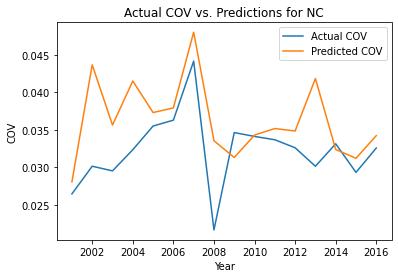

In [248]:
state='NC'
state_data = real_values[real_values['State']==state]
plt.plot(state_data['Year'],state_data['target_COV'],label='Actual COV')
plt.plot(state_data['Year'],state_data['Predictions'],label='Predicted COV')
plt.title('Actual COV vs. Predictions for {}'.format(state))
plt.xlabel('Year')
plt.ylabel('COV')
plt.legend();

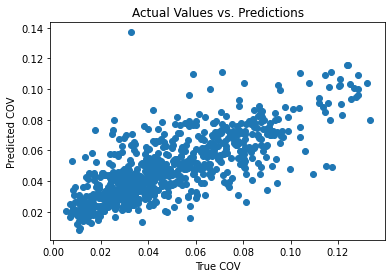

In [250]:
plt.scatter(real_values['target_COV'],real_values['Predictions'])
plt.title('Actual Values vs. Predictions')
plt.xlabel('True COV')
plt.ylabel('Predicted COV');

# The rest below is scratch work and can be disregarded at the moment.

In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    COV   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                              227.2
Date:                Fri, 22 Oct 2021   Prob (F-statistic):                   7.00e-221
Time:                        18:42:06   Log-Likelihood:                          1537.9
No. Observations:                 649   AIC:                                     -3052.
Df Residuals:                     637   BIC:                                     -2998.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Months Above Average Price Movement NG=F    -0.0030      0.001     -4.218      0.000      -0.004      -0.002
Months Above Average Price Movement CL=F    -0.0034      0.001     -3.915      0.000      -0.005      -0.002
Months Above Average Price Movement HO=F     0.0062      0.001      7.159      0.000       0.004       0.008
Months Above Average Price Volume HO=F       0.0071      0.001     10.843      0.000       0.006       0.008
Agg_total_plant_count                     2.396e-06   5.25e-07      4.565      0.000    1.37e-06    3.43e-06
R_AB_MWh                                    13.1294      2.095      6.268      0.000       9.016      17.243
R_MSW_count                                 16.8578      4.989      3.379      0.001       7.061      26.654
R_OBG_MWh                                   -8.7589      1.840     -4.761      0.000     -12.372      -5.146
R_OTH_MWh                                    1.9827      0.387      5.128      0.000       1.223       2.742
R_SLW_count                                  0.3286      0.147      2.242      0.025       0.041       0.616
Carbon Policy                               -0.0143      0.002     -6.597      0.000      -0.019      -0.010
SERC                                        -0.0098      0.002     -4.296      0.000      -0.014      -0.005
==============================================================================
Omnibus:                       48.017   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.311
Skew:                           0.726   Prob(JB):                     3.59e-13
Kurtosis:                       3.108   Cond. No.                     1.63e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# create some interaction terms
poly = PolynomialFeatures(degree=2,interaction_only=True)
polynomials = poly.fit_transform(x)
polynomial_names = poly.get_feature_names(x.columns)
poly_x = pd.DataFrame(polynomials,columns=polynomial_names)

In [ ]:
(floatlen(initial_good_variables)

4

In [ ]:
count_columns = []
mwh_columns = []
for col in data.columns[16:]:
  if 'Mwh' in col:
    mwh_columns.append(col)
  elif 'count' in col:
    count_columns.append(col)

In [ ]:
data[count_columns].corr()

,R_AB_count,R_BFG_count,R_BIT_count,R_BLQ_count,R_DFO_count,R_GEO_count,R_JF_count,R_KER_count,R_LFG_count,R_LIG_count,R_MSB_count,R_MSN_count,R_MSW_count,R_MWH_count,R_NG_count,R_NUC_count,R_OBG_count,R_OBS_count,R_OG_count,R_OTH_count,R_OUC_custom_count,R_PC_count,R_PG_count,R_PUR_count,R_RC_count,R_RFO_count,R_SC_count,R_SGC_count,R_SLW_count,R_SUB_count,R_SUN_count,R_TDF_count,R_WAT_count,R_WC_count,R_WDS_count,R_WH_count,R_WND_count,R_WO_count
R_AB_count,1.000000,-0.061257,-0.126234,0.178942,0.130712,-0.047962,-0.054916,-0.085843,-0.265041,0.377369,-0.053610,-0.053610,0.008632,-0.053972,0.060604,-0.045102,-0.156338,-0.029084,0.141096,0.279895,-0.093654,0.086672,0.066301,0.159943,-0.010671,0.104052,-0.010030,0.021326,-0.050326,0.104494,-0.148536,0.328375,-0.235987,-0.101423,0.009971,0.136843,0.243625,0.185083
R_BFG_count,-0.061257,1.000000,0.370989,-0.090738,-0.032014,-0.032207,-0.047228,-0.056481,0.183434,-0.038322,0.005831,0.005831,-0.011479,-0.030682,0.053248,-0.088203,0.103182,-0.075827,0.129580,0.046950,0.240301,0.048094,-0.073919,-0.054258,-0.032639,-0.055472,-0.029138,0.476542,-0.044441,0.018657,-0.003743,-0.010276,-0.105577,-0.053988,-0.086826,0.059948,-0.050651,-0.071971
R_BIT_count,-0.126234,0.370989,1.000000,0.142012,0.152464,-0.100203,-0.116895,-0.130167,0.344464,-0.168769,-0.075010,-0.075010,-0.054287,0.045523,0.022530,0.210763,-0.029127,0.020983,0.060135,0.027890,0.113109,0.291178,0.186257,-0.127885,0.155179,-0.112719,0.235067,0.213756,0.154281,-0.042637,-0.163839,0.125709,-0.155302,0.284434,0.050509,-0.120554,-0.344818,0.034110
R_BLQ_count,0.178942,-0.090738,0.142012,1.000000,-0.159034,-0.108434,-0.144986,-0.178983,-0.095998,-0.026649,-0.085697,-0.085697,-0.019955,-0.103708,0.218208,0.419851,-0.048081,0.220209,0.077354,0.298242,0.170851,0.171127,0.064343,0.307851,-0.046805,0.206637,0.031172,-0.038782,0.513440,-0.182277,-0.203214,0.460154,0.029980,-0.141212,0.717211,-0.004912,-0.324427,0.022567
R_DFO_count,0.130712,-0.032014,0.152464,-0.159034,1.000000,-0.203029,0.336201,0.030157,0.106382,-0.054035,0.019060,0.019060,0.039448,-0.091307,0.056239,0.094724,-0.166444,0.068593,-0.227831,-0.079535,0.000711,0.007515,-0.047232,-0.146853,-0.045006,0.060512,0.061335,-0.031263,-0.133306,0.161698,-0.316904,0.078321,-0.405548,-0.001443,-0.251271,-0.256909,-0.127216,0.100233
R_GEO_count,-0.047962,-0.032207,-0.100203,-0.108434,-0.203029,1.000000,-0.041373,-0.054052,-0.085741,-0.042107,-0.087470,-0.087470,-0.012613,-0.029397,0.045184,-0.154455,-0.029429,-0.072811,0.067054,-0.053334,-0.065790,-0.093730,-0.070489,-0.055541,-0.054385,-0.027842,-0.013846,-0.027995,-0.081719,-0.029452,0.147560,-0.109335,-0.018638,-0.039919,-0.134793,0.127114,-0.101635,-0.043856
R_JF_count,-0.054916,-0.047228,-0.116895,-0.144986,0.336201,-0.041373,1.000000,0.081505,-0.147408,-0.019119,0.068928,0.068928,-0.018496,0.114911,-0.254088,-0.097682,-0.143686,0.015318,-0.092041,-0.059945,0.033497,-0.138036,-0.074071,-0.067633,-0.044743,0.078937,-0.044403,-0.041052,-0.093698,-0.049023,-0.121853,-0.097417,0.072298,0.123069,-0.071537,-0.116386,-0.119022,0.154755
R_KER_count,-0.085843,-0.056481,-0.130167,-0.178983,0.030157,-0.054052,0.081505,1.000000,0.097477,-0.073843,0.496424,0.496424,-0.022120,-0.014646,-0.014113,0.029100,-0.110878,-0.133633,-0.024354,0.014300,-0.014636,0.023740,-0.010806,-0.086917,-0.102788,0.237504,-0.053411,-0.049095,-0.121316,-0.232365,0.117143,-0.093663,-0.044268,-0.094673,-0.179254,-0.127949,-0.196707,0.000664
R_LFG_count,-0.265041,0.183434,0.344464,-0.095998,0.106382,-0.085741,-0.147408,0.097477,1.000000,-0.204407,0.137484,0.137484,-0.040580,-0.130914,0.037087,0.162408,0.073389,0.037465,-0.132697,-0.109325,0.034343,0.208519,0.125539,-0.136013,-0.056916,0.145596,0.146662,0.096855,-0.034489,-0.349037,0.075891,-0.011896,-0.126754,0.069643,0.027622,-0.221353,-0.324657,-0.112201
R_LIG_count,0.377369,-0.038322,-0.168769,-0.026649,-0.054035,-0.042107,-0.019119,-0.073843,-0.204407,1.000000,-0.124417,-0.124417,-0.015008,-0.039176,-0.119083,-0.

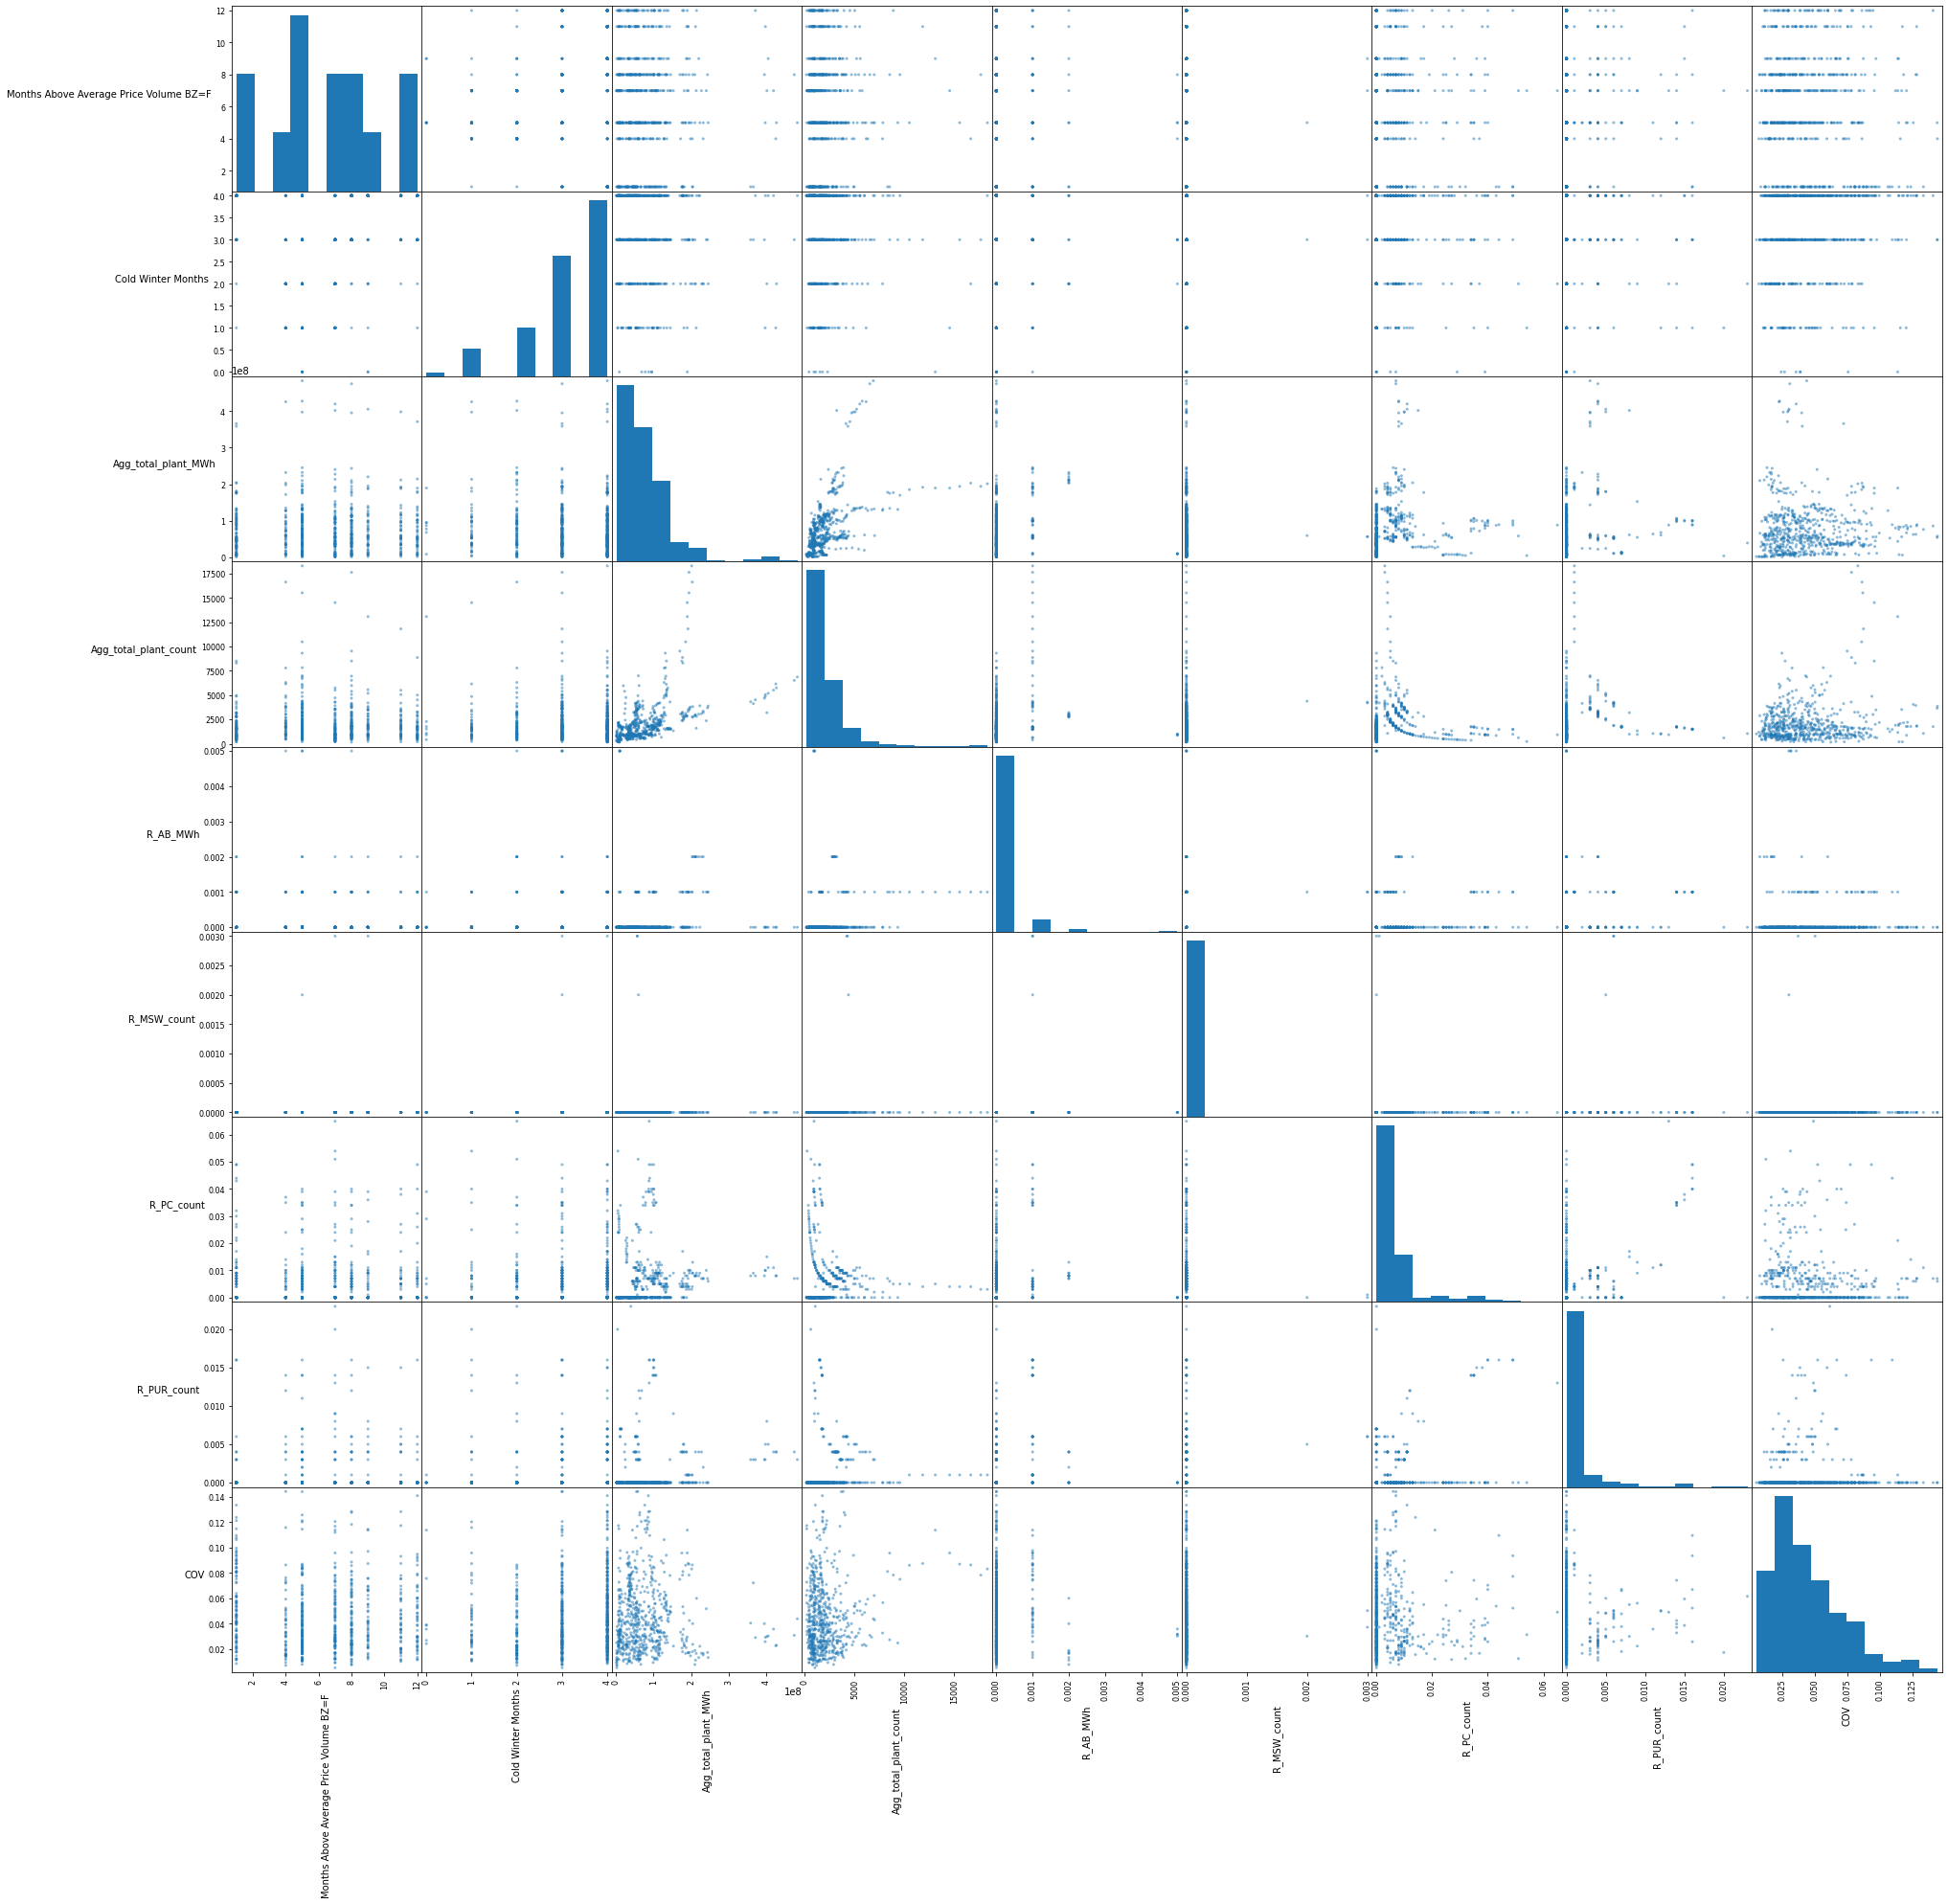

In [ ]:
axes = pd.plotting.scatter_matrix(data[next_round_variables+['COV']], figsize=(32,32))
for ax in axes.flatten():
  ax.xaxis.label.set_rotation(90)
  ax.yaxis.label.set_rotation(0)
  ax.yaxis.label.set_ha('right')
#plt.savefig('Scatterplot_matrix_next_round_vars.png')

In [ ]:
 # do some initial regression model
x['constant'] = [1]*x.shape[0]

In [ ]:
del x['State']
del x['Year']

In [ ]:
mod = sm.OLS(y.astype(float), x.astype(float))
res = mod.fit()

In [ ]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    COV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     8.232
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           2.20e-56
Time:                        15:54:59   Log-Likelihood:                 1678.7
No. Observations:                 649   AIC:                            -3191.
Df Residuals:                     566   BIC:                            -2820.
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [ ]:
next_round_variables = list(res.pvalues[res.pvalues<0.1].index)

In [ ]:
mod2 = sm.OLS(y.astype(float), x[next_round_variables].astype(float))
res2 = mod2.fit()

In [ ]:
print(res2.summary())

                                 OLS Regression Results                                
Dep. Variable:                    COV   R-squared (uncentered):                   0.747
Model:                            OLS   Adj. R-squared (uncentered):              0.744
Method:                 Least Squares   F-statistic:                              237.0
Date:                Fri, 22 Oct 2021   Prob (F-statistic):                   7.92e-186
Time:                        15:55:09   Log-Likelihood:                          1444.3
No. Observations:                 649   AIC:                                     -2873.
Df Residuals:                     641   BIC:                                     -2837.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [ ]:
predictions = res2.predict(x[next_round_variables].astype(float))

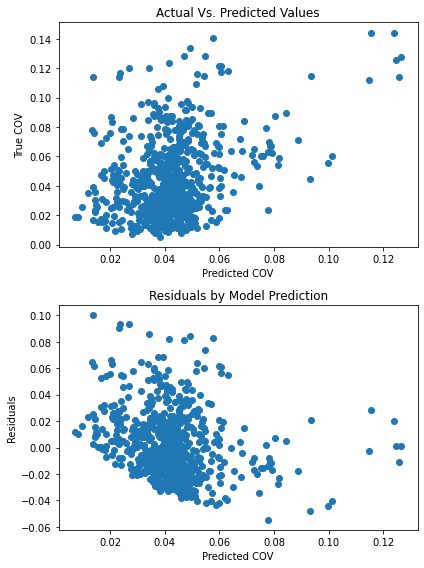

In [ ]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)

ax[0].scatter(predictions, y)
ax[0].set_xlabel('Predicted COV')
ax[0].set_ylabel('True COV')
ax[0].set_title('Actual Vs. Predicted Values')

ax[1].scatter(predictions,y-predictions)
ax[1].set_xlabel('Predicted COV')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals by Model Prediction')

fig.tight_layout()

In [ ]:
# now let's try this again but with the square root of the COV as the target variable
mod3 = sm.OLS(np.sqrt(y).astype(float), x[next_round_variables].astype(float))
res3 = mod3.fit()

In [ ]:
predictions = res3.predict(x[next_round_variables].astype(float))

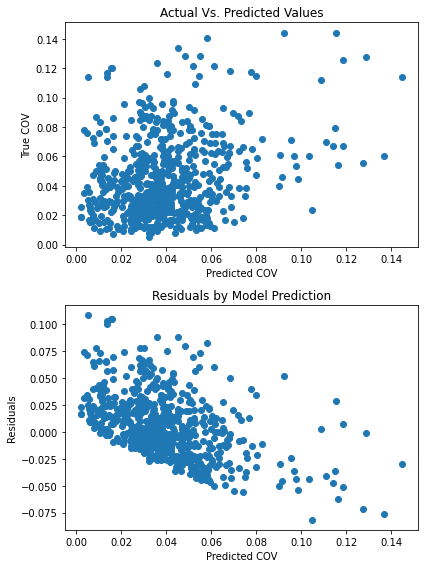

In [ ]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)

ax[0].scatter(predictions.pow(2), y)
ax[0].set_xlabel('Predicted COV')
ax[0].set_ylabel('True COV')
ax[0].set_title('Actual Vs. Predicted Values')

ax[1].scatter(predictions.pow(2),y-predictions.pow(2))
ax[1].set_xlabel('Predicted COV')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals by Model Prediction')

fig.tight_layout()

In [ ]:
print(res3.summary())

                                 OLS Regression Results                                
Dep. Variable:                    COV   R-squared (uncentered):                   0.884
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                              611.4
Date:                Fri, 22 Oct 2021   Prob (F-statistic):                   3.80e-294
Time:                        15:57:17   Log-Likelihood:                          788.80
No. Observations:                 649   AIC:                                     -1562.
Df Residuals:                     641   BIC:                                     -1526.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [ ]:
final_round_variables = list(res3.pvalues[res3.pvalues<0.05].index)

In [ ]:
mod4 = sm.OLS(y.astype(float), x[final_round_variables].astype(float))
res4 = mod4.fit()

In [ ]:
predictions = res4.predict(x[final_round_variables].astype(float))

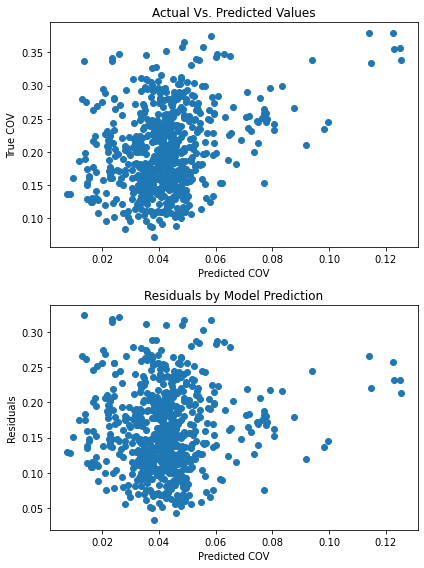

In [ ]:
fig, ax = plt.subplots(2)
fig.set_size_inches(6,8)

ax[0].scatter(predictions, np.sqrt(y))
ax[0].set_xlabel('Predicted COV')
ax[0].set_ylabel('True COV')
ax[0].set_title('Actual Vs. Predicted Values')

ax[1].scatter(predictions,np.sqrt(y)-predictions)
ax[1].set_xlabel('Predicted COV')
ax[1].set_ylabel('Residuals')
ax[1].set_title('Residuals by Model Prediction')

fig.tight_layout()

In [ ]:
print(res4.summary())

                                 OLS Regression Results                                
Dep. Variable:                    COV   R-squared (uncentered):                   0.747
Model:                            OLS   Adj. R-squared (uncentered):              0.745
Method:                 Least Squares   F-statistic:                              316.4
Date:                Fri, 22 Oct 2021   Prob (F-statistic):                   3.72e-188
Time:                        15:57:37   Log-Likelihood:                          1443.9
No. Observations:                 649   AIC:                                     -2876.
Df Residuals:                     643   BIC:                                     -2849.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [ ]:
final_final

In [ ]:
fuel_types_1_dict = {
                "hydroelectric":"WAT",
                "bituminous coal": "BIT",
                "subbituminous coal":"SUB",
                "black liquour":"BLQ",
                "tire-derived fuels":"TDF",
                "petroleum coke": "PC",
                "synthetic coal":"SC",
                "biogenic municipal solid waste":"MSB",
                "Disolate Fue Oil":"DFO",
                "Other":"OTH",
                "landfill gas":"LFG",
                "gaseous propane":"PG",
                "waste/other coal":"WC",
                "waste/other oil":"WO",
                "other gas":"OG",
                "kerosene":"KER",
                "residual fuel oil":"RFO",
                "lignite coal":"LIG",
                            
                "other biomass solids":"OBS",
                "jet fuel":"JF",

                "coal-derived synthetic gas":"SGC",
                "blast furnace gas": "BFG",
                "Wind":"WND",
                "Solar": "SUN",
                "Nuclear":"NUC",
                "agricultural by-products":"AB",
                "sludge waste":"SLW",
                "purchased steam":"PUR",
                "other biomass gas":"OBG",
                "subbituminous coal":"SUB",
                "geothermal":"GEO",
                "batteries or other use of electricity as an energy source":"MWH",
                "waste heat": "WH","non-biogenic municipal solid waste":"MSN",
                "wood/wood waste solids":"WDS",
                "municipal solid waste":"MSW",
                "Natural Gas":"NG",
                "biogenic municipal solid waste":"MSB",
                "refined coal":"RC",

}
